In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
import networkx as nx
import numpy as np
from random import choices
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
import pandas as pd
from networkx.algorithms.community import greedy_modularity_communities, modularity
from time import time
import matplotlib.cm as cm
from networkx.algorithms.smallworld import omega

In [243]:
U2U = pd.read_csv("/content/drive/MyDrive/Curriculars/HS3100 project/weights/Exposure_probability_weights_U2U.csv", index_col = 0).transpose()
F2U = pd.read_csv("/content/drive/MyDrive/Curriculars/HS3100 project/weights/Exposure_probability_weights_F2U.csv", index_col = 0).transpose()
U2F = pd.read_csv("/content/drive/MyDrive/Curriculars/HS3100 project/weights/Exposure_probability_weights_U2F.csv", index_col = 0).transpose()
F2F = pd.read_csv("/content/drive/MyDrive/Curriculars/HS3100 project/weights/Exposure_probability_weights_F2F.csv", index_col = 0).transpose()

def U2Urv(n=1):
    return choices(U2U['Exposure']*10**6, 10 ** U2U['Weights'], k=n)

def F2Urv(n=1):
    return choices(F2U['Exposure']*10**6, 10 ** F2U['Weights'], k=n)

def U2Frv(n=1):
    return choices(U2F['Exposure']*10**6, 10 ** U2F['Weights'], k=n)

def F2Frv(n=1):
    return choices(F2F['Exposure']*10**6, 10 ** F2F['Weights'], k=n)

In [244]:
# 17 Domestic Banks, 240 International Banks, 50000 Firms
def BankingGraph(Nd, Ni, Nf,rs):
    G = nx.DiGraph()
    np.random.seed(rs+1)
    # Domestic Banks
    DBrv = U2Urv(int((Nd * (Nd-1))/2))
    ctr = 0
    for i in range(Nd):
        for j in range(i+1, Nd):
            if np.random.random() < 0.5:
                G.add_edge(i, j, weight = DBrv[ctr]); # Domestic Bank - Domestic Bank
            else:
                G.add_edge(j, i, weight = DBrv[ctr]); # Domestic Bank - Domestic Bank

            ctr = ctr + 1;
    
    # International Banks
    K2 = int(10 * Ni/240)
    if K2 <2:
        K2 = 2
    G_o = nx.generators.watts_strogatz_graph(Ni, K2, 0.3,seed = rs)
    IBrv = F2Frv(len(G_o.edges)+1)
    ctr = 0
    for i,j in G_o.edges:
        if np.random.random() < 0.5:
            G.add_edge(Nd+i, Nd+j, weight = IBrv[ctr]) # International Bank - International Bank
        else:
            G.add_edge(j+Nd, Nd+i, weight = IBrv[ctr]) # International Bank - International Bank
        ctr = ctr + 1;
    
    L = int(Ni*Nd * (0.05 * np.random.random() + 0.20))

    for i in range(L):
        DB = np.random.randint(Nd)
        OB = np.random.randint(Nd, Ni + Nd)
        if np.random.random() < 0.5:
            G.add_edge(OB, DB, weight = F2Urv()[0]); # International Bank - Domestic Bank
        else:
            G.add_edge(DB, OB, weight = U2Frv()[0]); # Domestic Bank - International Bank

    # Firms
    for i in range(Nf):
        if np.random.random() < 0.75:
            k = np.random.randint(0,Nd)
            G.add_edge(i+Nd+Ni, k)
        else:
            k = np.random.randint(Nd, Ni + Nd)
            G.add_edge(i+ Nd + Ni, k)
    return G


#Control
def ERGraph(Nd, Ni, Nf, rs):
    K2 = int(10 * Ni/ 240)
    if K2<2:
        K2 = 2
    elif K2%2==1:
        K2 = int(10 * Ni/240)
    p = (Nd*(Nd-1)/2 + K2*Ni/2 + 0.225*Ni*Nd)/((Ni+Nd)*(Ni+Nd-1)/2)
    G = nx.fast_gnp_random_graph(Nd+Ni, p, directed= True, seed = rs)
    np.random.seed(rs)
    #Adding weights
    for i,j in G.edges:
        if i<Nd and j<Nd:
            G.edges[(i,j)]['weight'] = U2Urv()[0]
        elif i<Nd:
            G.edges[(i,j)]['weight'] = U2Frv()[0]
        elif j<Nd:
            G.edges[(i,j)]['weight'] = F2Urv()[0]
        else:
            G.edges[(i,j)]['weight'] = F2Frv()[0]

    # Firms
    for i in range(Nf):
        if np.random.random() < 0.75:
            k = np.random.randint(0,Nd)
            G.add_edge(i+Nd+Ni, k)
        else:
            k = np.random.randint(Nd, Ni + Nd)
            G.add_edge(i+ Nd + Ni, k)
    return G


In [275]:
6.3 * 10**(-1.5)

0.19922349259060787

In [252]:
def simulate(mu_G, Edge_list, Q):
    pi = np.random.randint(4,25)/100
    alpha = 0.5
    lam = 0.67
    phi = 0.4/len(Edge_list)
    psi = 0.2/(Nf)
    mean_ig = 8.65 * 10**(-3) #0.1*Nf*phi
    sd_ig = mean_ig/4
    mean_nig = 6.3*10**(-1.5)
    sd_nig = mean_nig/10
    beta = 0.35
    q_t = 1
    avg_failed = 0.0
    f = False
    firm_solvent = {i:0 for i in range(Ni+Nd, Ni+Nd+Nf)}; bank_solvent = [0 for i in range(Ni+Nd)]; bank_abstain = [0 for i in range(Ni+Nd)];
    loss_jc = [0 for i in range(Ni+Nd)]; loss_jtot = [0 for i in range(Ni+Nd)]; loss_jf = [0 for i in range(Ni+Nd)]; q_t = 1; 

    for t in range(1000):
        #Update
        #Compute loss_jc,loss_jf            
        for i in Edge_list:
            if(i[0] >= Nd+Ni and i[3] == 'Equity'):
                loss_jf[i[1]] += firm_solvent[i[0]]*(i[2])
            elif(i[0] >= Nd+Ni and i[3] == 'Loan'):
                loss_jf[i[1]] += firm_solvent[i[0]]*(i[2])*(1-beta)
            else:
                loss_jc[i[1]] += (i[2]*bank_solvent[i[0]])
        # Compute bank_abstain
        for i in range(Ni+Nd):
            X = loss_jc[i]+loss_jf[i]-alpha*pi*assets[i]
            if(X>0):
                bank_abstain[i] = 1
            else:
                bank_abstain[i] = 0
        #Compute Q_t
        Q_t = 0
        for i in Edge_list:
            if(i[0] >= Nd+Ni and i[3] == 'Equity'):
                Q_t+= bank_abstain[i[1]]*i[2]
        #Upate q_t
        try:
            q_t = q_t*(1-(lam)*(Q_t/(Q-Q_t)))
        except:
            return 1
        #Update lj_tot
        for i in range(Ni+Nd):
            loss_jtot[i] = loss_jc[i]+loss_jf[i]
        for i in Edge_list:
            if(i[0] >= Nd+Ni and i[3] == 'Equity'):
                loss_jtot[i[1]] += (i[2])*(1-q_t)*(1 - firm_solvent[i[0]])
        #Update bank_solvent, firm_solvent
        for i in range(Ni+Nd):
            X = loss_jtot[i]-pi*assets[i]
            if(X>0):
                bank_solvent[i] = 1
            else:
                bank_solvent[i] = 0
        for i in range(Nd+Ni,Nf+Nd+Ni):
            firm_solvent[i] = mu_G+rand_firms[i]
        for i in Edge_list:
            if(i[0] >= Nd+Ni):
                firm_solvent[i[0]] += phi*(bank_abstain[i[1]])
        for i in range(Nd+Ni,Nf+Nd+Ni):
            if (firm_solvent[i] > 0.5):
                firm_solvent[i] = 1
            else:
                firm_solvent[i] = 0
        #Compute failed
        failed = 0.0
        flag = 0
        failed_firms = np.sum(list(firm_solvent.values()))
        if t>5:
            prev_firms = failed_firms
        if t>10:
            if failed_firms == prev_firms:
                break
        for i in range(Nd+Ni):
            failed+=bank_solvent[i]
        
    return failed/(Nd+Ni)
print('************Execution Started*************')
l = [17,240,40000,23]
network_type = 'BG'
print(l, network_type)
Nd = l[0]
Ni = l[1]
Nf = l[2]
np.random.seed(l[3])
if network_type == 'ER':
    G = ERGraph(Nd,Ni,Nf,l[3])
else:
    G = BankingGraph(Nd,Ni,Nf, l[3])
Edge_list = []
Count = 0
    
for i in list(G.edges):
    if(i[0]<Nd+Ni and i[1]<Nd+Ni):
        Edge_list.append([i[0], i[1], G.edges[i]['weight']]) # Exposure Assumption
    else:
        if np.random.rand()>0.5:
            Edge_list.append([i[0], i[1], np.random.poisson(4000*5),'Equity'])
        else:
            Edge_list.append([i[0], i[1], np.random.poisson(3200*5),'Loan'])
            Count+=1
Nodes = []
for i in list(G.nodes()):
    if i < Nd+Ni:
        Nodes.append([i])
    else:
        if np.random.rand()<0.7:
            Nodes.append([i,'Investment'])
        else:
            Nodes.append([i,'Speculative'])
pi = np.random.randint(4,25)/100
alpha = 0.5
lam = 0.67
phi = 0.4/len(Edge_list)
psi = 0.2/(Nf)
mean_ig = 8.65 * 10**(-3) #0.1*Nf*phi
sd_ig = mean_ig/4
mean_nig = 6.3*10**(-1.5)
sd_nig = mean_nig/10
beta = 0.35
assets = {}
liabilities = {}
Q = 0
for i in range(Nd+Ni):
    assets[i] = 0
    liabilities[i] = 0
for i in Edge_list:
    if (len(i) == 4 and i[3] == 'Equity'):
        Q+=i[2]
    if(i[0] < Nd+Ni):
        liabilities[i[0]]+=i[2]
    if(i[1] < Nd+Ni):
        assets[i[1]]+=i[2] 
for i in range(Nd+Ni):
    liabilities[i] += pi*(assets[i])

    
bank_solvent = {}
firm_solvent = {}
bank_abstain = {}
loss_jc = {}
loss_jtot = {}
loss_jf = {}
for i in range(Nd+Ni,Nf+Nd+Ni):
    firm_solvent[i] = 0
for i in range(Nd+Ni):
    bank_abstain[i] = 0
    bank_solvent[i] = 0
    loss_jc[i] = 0
    loss_jtot[i] = 0
    loss_jf[i] = 0
rand_firms = {}
for i in Nodes:
    if(len(i) == 2):
        if (i[1] == 'Investment'):
            rand_firms[i[0]] = sd_ig*np.random.randn()+mean_ig
        else:
            rand_firms[i[0]] = sd_nig*np.random.randn()+mean_nig
q_t = 1
L = []
mu_crit = 0
final_flag = False
t3 = time()
L = []
for i in tqdm(np.linspace(0.1,0.5,200)):
    L.append(simulate(i,Edge_list,Q))


************Execution Started*************
[17, 240, 40000, 23] BG


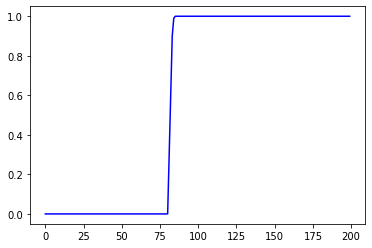

In [271]:
q = [np.mean(L[i:i+10]) for i in range(len(L) -10)]
#plt.figure(figsize=(6,3))
#plt.plot(np.linspace(0.1,0.5,len(q)), q, c = 'blue')
plt.plot(range(len(L)), L, c = 'blue')

#L[79:88] = [0,0.2,0.2,0.42,0.42,0.6,0.6,0.9,0.9,1]

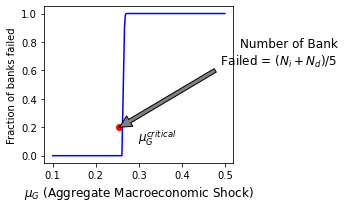

In [272]:
#q = [np.mean(L[i:i+]) for i in range(len(L) -15)]
plt.figure(figsize=(6,3))
plt.plot(np.linspace(0.1,0.5,len(L)), L, c = 'blue')
plt.xlabel("$\mu_G$ (Aggregate Macroeconomic Shock)", fontsize = 12)
plt.ylabel("Fraction of banks failed",fontsize = 10)
plt.annotate("$\mu_G^{critical}$",
            xy=(0.255, 0.30), xycoords='data',
            xytext=(0.7,0.1), textcoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom',fontsize = 12)
#plt.annotate("$\mu_G^{critical}", xy = (0.24,-0.5), xytext = )
plt.annotate("Number of Bank\n Failed = $(N_i+N_d)/5$",
            xy=(0.255, 0.2), xycoords='data',
            xytext=(1.55, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='grey', shrink=0),
            horizontalalignment='right', verticalalignment='top', fontsize = 12)
plt.scatter([0.255], [0.2], c = 'red')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Curriculars/HS3100 project/Figures/mu_critical_BG.jpg",dpi = 200, fmt = 'jpg')

In [ ]:
def get_attr(l, network_type = 'ER'):
    def simulate(mu_G, Edge_list, Q):
        pi = np.random.randint(4,25)/100
        alpha = 0.5
        lam = 0.67
        phi = 0.4/len(Edge_list)
        psi = 0.2/(Nf)
        mean_ig = 8.65 * 10**(-3) #0.1*Nf*phi
        sd_ig = mean_ig/4
        mean_nig = 6.3*10**(-1.5)
        sd_nig = mean_nig/10
        beta = 0.35
        q_t = 1
        avg_failed = 0.0
        f = False
        firm_solvent = {i:0 for i in range(Ni+Nd, Ni+Nd+Nf)}; bank_solvent = [0 for i in range(Ni+Nd)]; bank_abstain = [0 for i in range(Ni+Nd)];
        loss_jc = [0 for i in range(Ni+Nd)]; loss_jtot = [0 for i in range(Ni+Nd)]; loss_jf = [0 for i in range(Ni+Nd)]; q_t = 1; 

        for t in range(1000):
            #Update
            #Compute loss_jc,loss_jf            
            for i in Edge_list:
                if(i[0] >= Nd+Ni and i[3] == 'Equity'):
                    loss_jf[i[1]] += firm_solvent[i[0]]*(i[2])
                elif(i[0] >= Nd+Ni and i[3] == 'Loan'):
                    loss_jf[i[1]] += firm_solvent[i[0]]*(i[2])*(1-beta)
                else:
                    loss_jc[i[1]] += (i[2]*bank_solvent[i[0]])
            # Compute bank_abstain
            for i in range(Ni+Nd):
                X = loss_jc[i]+loss_jf[i]-alpha*pi*assets[i]
                if(X>0):
                    bank_abstain[i] = 1
                else:
                    bank_abstain[i] = 0
            #Compute Q_t
            Q_t = 0
            for i in Edge_list:
                if(i[0] >= Nd+Ni and i[3] == 'Equity'):
                    Q_t+= bank_abstain[i[1]]*i[2]
            #Update q_t
            try:
                q_t = q_t*(1-(lam)*(Q_t/(Q-Q_t)))
            except:
                return True
            #Update lj_tot
            for i in range(Ni+Nd):
                loss_jtot[i] = loss_jc[i]+loss_jf[i]
            for i in Edge_list:
                if(i[0] >= Nd+Ni and i[3] == 'Equity'):
                    loss_jtot[i[1]] += (i[2])*(1-q_t)*(1 - firm_solvent[i[0]])
            #Update bank_solvent, firm_solvent
            for i in range(Ni+Nd):
                X = loss_jtot[i]-pi*assets[i]
                if(X>0):
                    bank_solvent[i] = 1
                else:
                    bank_solvent[i] = 0
            for i in range(Nd+Ni,Nf+Nd+Ni):
                firm_solvent[i] = mu_G+rand_firms[i]
            for i in Edge_list:
                if(i[0] >= Nd+Ni):
                    firm_solvent[i[0]] += phi*(bank_abstain[i[1]])
            for i in range(Nd+Ni,Nf+Nd+Ni):
                if (firm_solvent[i] > 0.5):
                    firm_solvent[i] = 1
                else:
                    firm_solvent[i] = 0
            #Compute failed
            failed = 0.0
            flag = 0
            failed_firms = np.sum(list(firm_solvent.values()))
            if t>5:
                prev_firms = failed_firms
            if t>10:
                if failed_firms == prev_firms:
                    break
            for i in range(Nd+Ni):
                failed+=bank_solvent[i]
                if(failed>= (Ni+Nd)/5):
                    flag = 1
                    break
            if(flag == 1):
                mu_crit = mu_G
                f = True
                break
            avg_failed += (failed)/1000
        return f

    print('************Execution Started*************')
    print(l, network_type)
    Nd = l[0]
    Ni = l[1]
    Nf = l[2]
    np.random.seed(l[3])
    if network_type == 'ER':
        G = ERGraph(Nd,Ni,Nf,l[3])
    else:
        G = BankingGraph(Nd,Ni,Nf, l[3])
    Edge_list = []
    Count = 0
    
    for i in list(G.edges):
        if(i[0]<Nd+Ni and i[1]<Nd+Ni):
            Edge_list.append([i[0], i[1], G.edges[i]['weight']]) # Exposure Assumption
        else:
            if np.random.rand()>0.5:
                Edge_list.append([i[0], i[1], np.random.poisson(4000*5),'Equity'])
            else:
                Edge_list.append([i[0], i[1], np.random.poisson(3200*5),'Loan'])
                Count+=1
                
    Nodes = []
    for i in list(G.nodes()):
        if i < Nd+Ni:
            Nodes.append([i])
        else:
            if np.random.rand()<0.7:
                Nodes.append([i,'Investment'])
            else:
                Nodes.append([i,'Speculative'])
    
    pi = np.random.randint(4,25)/100
    alpha = 0.5
    lam = 0.67
    phi = 0.4/len(Edge_list)
    psi = 0.2/(Nf)
    mean_ig = 8.65 * 10**(-3) #0.1*Nf*phi
    sd_ig = mean_ig/4
    mean_nig = 6.3*10**(-1.5)
    sd_nig = mean_nig/10
    beta = 0.35
    assets = {}
    liabilities = {}
    Q = 0
    for i in range(Nd+Ni):
        assets[i] = 0
        liabilities[i] = 0
    for i in Edge_list:
        if (len(i) == 4 and i[3] == 'Equity'):
            Q+=i[2]
        if(i[0] < Nd+Ni):
            liabilities[i[0]]+=i[2]
        if(i[1] < Nd+Ni):
            assets[i[1]]+=i[2] 
    for i in range(Nd+Ni):
        liabilities[i] += pi*(assets[i])

    
    bank_solvent = {}
    firm_solvent = {}
    bank_abstain = {}
    loss_jc = {}
    loss_jtot = {}
    loss_jf = {}
    for i in range(Nd+Ni,Nf+Nd+Ni):
        firm_solvent[i] = 0
    for i in range(Nd+Ni):
        bank_abstain[i] = 0
        bank_solvent[i] = 0
        loss_jc[i] = 0
        loss_jtot[i] = 0
        loss_jf[i] = 0
    rand_firms = {}
    for i in Nodes:
        if(len(i) == 2):
            if (i[1] == 'Investment'):
                rand_firms[i[0]] = sd_ig*np.random.randn()+mean_ig
            else:
                rand_firms[i[0]] = sd_nig*np.random.randn()+mean_nig
    q_t = 1
    L = []
    mu_crit = 0
    final_flag = False
    t3 = time()
    
    for depth in range(4):
        for Zi in range(0,10):
            mu_G = mu_crit + Zi / 10**(depth)
            if simulate(mu_G, Edge_list,Q):
                mu_crit = mu_G - 1.0/10**(depth)
                final_flag = True
                break
    if final_flag == False:
        print("mu not found")
        return False

    t4 = time()
    print("mu_critical: ", mu_crit)
    print("Run simulation: ", t4-t3)
    for i in range(Ni+Nd, Ni+Nd+Nf):
        G.remove_node(i)
    if network_type == 'ER':
        cc_list = nx.clustering(G,nodes = np.arange(0, Ni+Nd))
        cc_avg = np.mean(list(cc_list.values()))
    else:
        cc_list = nx.clustering(G, nodes = np.arange(Nd, Nd+Ni))
        cc_avg = np.mean(list(cc_list.values()) + [1.0 for i in range(Nd)])
    
    aspl = nx.average_shortest_path_length(G)
    und_G = nx.Graph()
    for i in G.edges:
        und_G.add_edge(i[0], i[1]) #, weight = 1/(G.edges[i]['weight']/10**6))
    #aspl = nx.average_shortest_path_length(und_G)
    c = list(greedy_modularity_communities(und_G))
    print(len(c), modularity(und_G,c))
    #t1 = time()
    #cyc = list(nx.simple_cycles(G))
    #t2 = time()
    #print(t2-t1)
    #num_loops = len(cyc)
    #avg_cyc_len = np.mean([len(i) for i in cyc])
    
    #loops_per_edge = num_loops/len(Edge_list)
    #print('loops_per_edge = '+str(loops_per_edge))
    #print('num_loops = '+str(num_loops))
    print('avg_clustering_coef =',cc_avg)
    #print('avg_cyc_len = '+str(avg_cyc_len))
    print('************Execution Done***************')
    #return [mu_crit, num_loops, avg_cyc_len, loops_per_edge, len(Edge_list), cc_avg, omega_G]
            #mu_crit, avg_cc, pathlen, #communities, modularity, #loops,        # avg cycle len, loops per edge
    return [mu_crit, cc_avg, aspl, len(c), modularity(und_G,c)]
    

### Simulated

In [ ]:
L = []


np.random.seed(400)
#L = [[np.random.randint(2,5), np.random.randint(10,13), np.random.randint(2000,4500), i] for i in range(50)]
L = [[np.random.randint(14,20),np.random.randint(200,300), np.random.randint(30000, 50000),i] for i in range(100)]
t1 = time()
#Final_obs= []

with Pool(3) as p:
    Final_obs = p.map(get_attr, L)


#for i in tqdm(range(len(L))):
#    Final_obs.append(get_attr(L[i]))

************Execution Started*************
[18, 279, 32366, 0] ER
************Execution Started*************
[15, 203, 38916, 18] ER
************Execution Started*************
[18, 290, 44621, 9] ER
mu_critical:  0.259
Run simulation:  27.318101406097412
4 0.13473142611130298
avg_clustering_coef = 0.06750567966222597
************Execution Done***************
************Execution Started*************
[14, 285, 47481, 19] ER
mu_critical:  0.261
Run simulation:  28.11267924308777
4 0.11663080246287832
avg_clustering_coef = 0.06371405594903022
************Execution Done***************
************Execution Started*************
[15, 212, 35107, 1] ER
mu_critical:  0.26899999999999996
Run simulation:  35.449464082717896
3 0.1148108744820949
avg_clustering_coef = 0.06658818724344011
************Execution Done***************
************Execution Started*************
[19, 244, 35068, 10] ER
mu_critical:  0.259
Run simulation:  24.310909271240234
3 0.1431182446660514
avg_clustering_coef = 0.06

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Curriculars/HS3100 project/ER_final_large_network.csv", index_col = 0)
len(df)

80

In [ ]:
for i in range(len(Final_obs)):
    Final_obs[i].append(2.234147974/Final_obs[i][2] - Final_obs[i][1]/0.6695)


df = pd.DataFrame(Final_obs, columns = ['ER_mu_critical', 'ER_avg_clustering_coef', 'ER_avg_shortest_path_len', 'ER_No_of_communities', 'ER_modularity', 'ER_Omega'])
df.to_csv("/content/drive/MyDrive/Curriculars/HS3100 project/ER_final_large_network.csv")
#df = pd.read_csv("/content/drive/MyDrive/Curriculars/HS3100 project/BG_undirected_small_network.csv", index_col = 0)
#sns.pairplot(df, kind='kde')
df.corr(method = 'spearman')

,ER_mu_critical,ER_avg_clustering_coef,ER_avg_shortest_path_len,ER_No_of_communities,ER_modularity,ER_Omega
ER_mu_critical,1.000000,-0.163445,-0.018563,0.111876,-0.179372,0.104750
ER_avg_clustering_coef,-0.163445,1.000000,-0.619286,-0.138467,0.077876,0.260174
ER_avg_shortest_path_len,-0.018563,-0.619286,1.000000,0.143418,0.585455,-0.910903
ER_No_of_communities,0.111876,-0.138467,0.143418,1.000000,0.069234,-0.106190
ER_modularity,-0.179372,0.077876,0.585455,0.069234,1.000000,-0.765029
ER_Omega,0.104750,0.260174,-0.910903,-0.106190,-0.765029,1.000000


In [ ]:
from scipy.stats import pearsonr
for i in df.columns:
    print(i, spearmanr(df['ER_mu_critical'], df[i]))

ER_mu_critical SpearmanrResult(correlation=1.0, pvalue=0.0)
ER_avg_clustering_coef SpearmanrResult(correlation=-0.16344496265669828, pvalue=0.10419514881298447)
ER_avg_shortest_path_len SpearmanrResult(correlation=-0.01856341909400046, pvalue=0.8545500106727881)
ER_No_of_communities SpearmanrResult(correlation=0.11187587822009917, pvalue=0.2677856814036044)
ER_modularity SpearmanrResult(correlation=-0.17937197806396546, pvalue=0.07415095419807315)
ER_Omega SpearmanrResult(correlation=0.10475029110468964, pvalue=0.29964740132284945)


In [ ]:
for i in range(len(Final_obs1)):
    Final_obs1[i].append(2.234147974/Final_obs1[i][2] - Final_obs1[i][1]/0.6695)

Final_obs1 = np.array(Final_obs1)

df = pd.DataFrame(Final_obs1, columns = ['BG_mu_critical', 'BG_avg_clustering_coef', 'BG_avg_shortest_path_len', 'BG_No_of_communities', 'BG_modularity', 'BG_Omega'])
#df.to_csv("/content/drive/MyDrive/Curriculars/HS3100 project/BG_und_large_network.csv")
#df = pd.read_csv("/content/drive/MyDrive/Curriculars/HS3100 project/BG_undirected_small_network.csv", index_col = 0)
#sns.pairplot(df, kind='kde')
df.corr(method = 'spearman')

,BG_mu_critical,BG_avg_clustering_coef,BG_avg_shortest_path_len,BG_No_of_communities,BG_modularity,BG_Omega
BG_mu_critical,1.000000,-0.158797,-0.108988,-0.194784,-0.030329,0.212304
BG_avg_clustering_coef,-0.158797,1.000000,-0.643842,0.177408,-0.770443,-0.280788
BG_avg_shortest_path_len,-0.108988,-0.643842,1.000000,0.295680,0.553202,-0.510345
BG_No_of_communities,-0.194784,0.177408,0.295680,1.000000,-0.035640,-0.613008
BG_modularity,-0.030329,-0.770443,0.553202,-0.035640,1.000000,0.163054
BG_Omega,0.212304,-0.280788,-0.510345,-0.613008,0.163054,1.000000


In [ ]:
from scipy.stats import pearsonr
for i in df.columns:
    print(i, spearmanr(df['BG_mu_critical'], df[i]))

BG_mu_critical SpearmanrResult(correlation=1.0, pvalue=0.0)
BG_avg_clustering_coef SpearmanrResult(correlation=-0.15879679360219756, pvalue=0.410638158361583)
BG_avg_shortest_path_len SpearmanrResult(correlation=-0.108987861447471, pvalue=0.5735836313891447)
BG_No_of_communities SpearmanrResult(correlation=-0.19478391640238582, pvalue=0.31127807617964703)
BG_modularity SpearmanrResult(correlation=-0.03032920126253152, pvalue=0.875891896616809)
BG_Omega SpearmanrResult(correlation=0.21230440883772067, pvalue=0.2688704781063425)


In [ ]:
def rand(i):
    print(np.random.randint(0,10))
    return None

L = [0 for i in range(10)]
with Pool(3) as p:
    L = p.map(rand, L)

2
2
2
0
0
0
6
6
6
3


In [ ]:
def rand(i):
    print(np.random.randint(0,10))
    return None

L = [0 for i in range(10)]
with Pool(1) as p:
    L = p.map(rand, L)

2
0
6
3
8
2
1
3
8
1


### Figure

In [ ]:
def draw_coloring(G,coloring,colors, sizes):
    fig = plt.figure()
    n_colors = max(list(coloring.values()))+1

    pos = nx.spring_layout(G)
    
    for i in range(n_colors):
        col = []; siz = []
        for x in G.nodes:
            if coloring[x] == i:
                col.append(x)
                siz.append(sizes[x])
        nx.draw_networkx_nodes(G,pos,col,node_color=colors[i], node_size = siz)
    nx.draw_networkx_edges(G,pos,width=0.5,alpha=0.1)
        
    plt.axis('off')
    plt.show() 
    return fig

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

5 0.33175066958850746
[frozenset({35, 4, 36, 38, 39, 40, 9, 37, 15, 21, 22, 29}), frozenset({1, 2, 6, 41, 42, 43, 44, 19, 20}), frozenset({0, 3, 10, 11, 12, 14, 16, 17, 18}), frozenset({7, 8, 45, 46, 23, 24, 25, 26, 28}), frozenset({32, 33, 34, 5, 13, 27, 30, 31})]


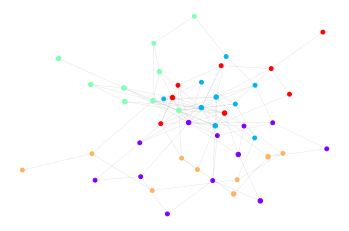

In [ ]:
G = BankingGraph(7,40,0,42)
Gi = nx.Graph()

for i in G.edges:
    Gi.add_edge(i[0], i[1]) #weight = 1/((G.edges[i]['weight']+1)/10**2))
H = greedy_modularity_communities(Gi)
print(len(H),modularity(Gi,H))
print(H)
colors = cm.rainbow(np.linspace(0, 1, len(H)))
ctr = 0
coloring={}

for arr in H:
    for i in arr:
       coloring[i] = ctr 
    ctr +=1

sizes = {i: 20 for i in range(17)}
for i in range(17, 17 +240):
    sizes[i] = 15

fig2 = draw_coloring(Gi, coloring, colors, sizes)

36

### Optimized?

In [ ]:
def opt_get_attr(l):
    print('************Execution Started*************')
    t1 = time()
    Nd = l[0]
    Ni = l[1]
    Nf = l[2]
    G = BankingGraph(Nd,Ni,Nf)
    Edge_list = []
    Count = 0
    Edge_map = {}
    
    t2 = time()
    print("Graph: ", t2-t1)
    for i in list(G.edges):
        if(i[0]<Nd+Ni and i[1]<Nd+Ni):
            Edge_list.append([i[0], i[1], G.edges[i]['weight'], 0]) # Exposure Assumption # 0 - Bank
        else:
            if np.random.rand()>0.5:
                Edge_list.append([i[0], i[1], np.random.poisson(4000), 1]) # 1 - Equity
            else:
                Edge_list.append([i[0], i[1], np.random.poisson(3200), 2]) # 2 - Loan
                Count+=1
    Edge_list = np.array(Edge_list)
    Nodes = []
    for i in list(G.nodes()):
        if i < Nd+Ni:
            Nodes.append([i])
        else:
            if np.random.rand()<0.7:
                Nodes.append([i,'Investment'])
            else:
                Nodes.append([i,'Speculative'])
  
    
    print("Number of Links: ", len(Edge_list))
    pi = np.random.randint(4,25)/100
    alpha = 0.5
    lam = 0.67
    phi = 0.4/(Count)
    mean_ig = 0.1*Nf*phi
    sd_ig = mean_ig/4
    mean_nig = 0.2*Nf*phi
    sd_nig = mean_nig/10
    beta = 0.35
    assets = np.array([0 for i in range(Nd + Ni)])
    liabilities = np.array([0 for i in range(Nd + Ni)])
    Q = np.sum(Edge_list[Edge_list[:,3] == 1,2])

    # Bank Sheet

    for i in Edge_list:
        if(i[0] < Nd+Ni):
            liabilities[int(i[0])]+=i[2]
        if(i[1] < Nd+Ni):
            assets[int(i[1])]+=i[2]
    for i in range(Nd+Ni):
        liabilities[i] += pi*(assets[i]) # Cash balance
    solvency = np.zeros(Nf+Nd+Ni)
    bank_abstain = np.zeros(Ni+Nd)
    loss_jc = np.zeros(Ni+Nd)
    loss_jtot = np.zeros(Ni+Nd)
    loss_jf = np.zeros(Ni+Nd)

    rand_firms = np.zeros(Ni+Nd+Nf)
    for i in Nodes:
        if(len(i) == 2):
            if (i[1] == 'Investment'):
                rand_firms[int(i[0])] = sd_ig*np.random.randn()+mean_ig
            else:
                rand_firms[int(i[0])] = sd_nig*np.random.randn()+mean_nig
    q_t = 1
    L = []
    mu_crit = 0

    t3 = time()
    print("Setting up: ", t3 - t2)
    for Z1 in range(300,1000):
        mu_G = (Z1+1)/1000
        #print(mu_G)
        avg_failed = 0.0
        f = 0
        solvency = np.zeros(Ni+Nd+Nf)
        bank_abstrain = np.zeros(Ni+Nd)
        loss_jc = np.zeros(Ni+Nd) 
        loss_jtot[:]= 0
        loss_jf[:] = 0
        for t in range(1000):
            #Update
            #Compute loss_jc,loss_jf            
            loss_jc[:Ni+Nd] = 0
            loss_jf[:Ni+Nd] = 0
            
            for i in Edge_list:
                if(i[3] == 1):
                    loss_jf[int(i[1])] += solvency[int(i[0])]*(i[2])
                elif(i[3] == 2):
                    loss_jf[int(i[1])] += solvency[int(i[0])]*(i[2])*(1-beta)
                else:
                    loss_jc[int(i[1])] += (i[2]*solvency[int(i[0])])

            # Compute bank_abstain
            
            X = loss_jc[:Ni+Nd] + loss_jf[:Ni+Nd] - alpha*pi*assets[:Ni+Nd]
            bank_abstain[X>0] = 1
            bank_abstain[X<0] = 0
            #Compute Q_t
            indices = Edge_list[Edge_list[:,3] == 1]
            Q_t = np.sum(bank_abstain[indices[:,1].astype(int)] * indices[:,2])
            
            #Update q_t
            q_t = q_t*(1-(lam)*(Q_t/(Q-Q_t)))
            
            #Update lj_tot
            
            loss_jtot[:Ni+Nd] = loss_jc[:Ni+Nd] + loss_jf[:Ni+Nd]

            for i in Edge_list:
                if(i[0] >= Nd+Ni and i[3] == 2):
                    loss_jtot[int(i[1])] += (i[2])*(1-q_t)*(1- solvency[int(i[0])])
            
            #Update bank_solvent, firm_solvent
            X = loss_jtot[:Ni+Nd] - pi*assets[:Ni+Nd]
            bank_solvent = np.zeros(Ni+Nd)
            bank_solvent[X>0] = 1;
            bank_solvent[X<0] = 0;
            solvency[:Ni+Nd] = bank_solvent[:Ni+Nd]

            # Firm solvent

            #solvency[Nd+Ni: Nf+ Nd + Ni] = mu_G + rand_firms[i]
            firm_solvent = np.zeros(Ni+Nd+Nf)
            firm_solvent = mu_G + rand_firms
            for i in Edge_list:
                if(i[0] >= Nd+Ni):
                    firm_solvent[int(i[0])] += phi*(bank_abstain[int(i[1])])
            
            firm_solvent[firm_solvent>0.5] = 1
            firm_solvent[firm_solvent<0.5] = 0
            solvency[Ni+Nd : Nd+Nf+Ni] = firm_solvent[Ni+Nd : Nd+Nf+Ni]

            #Compute failed ######################################################################################################
            failed = np.mean(solvency[:Nd+Ni])
            if failed > 0.5:
                flag = 1
                print("Done")
                break
            else:
                flag = 0
        
        if flag == 1:
            print('mu critical = '+str(mu_G))
            mu_crit = mu_G
            break
    t4 = time()
    print("Run simulation: ", t4-t3)
    cyc = list(nx.simple_cycles(G))
    print("Cycles done")
    cc_list = nx.clustering(G, nodes = np.arange(Nd, Nd+Ni))
    cc_avg = np.mean(list(cc_list.values()) + [1.0 for i in range(Nd)])
    num_loops = len(cyc)
    avg_cyc_len = np.mean([len(i) for i in cyc])
    
    loops_per_edge = num_loops/len(Edge_list)
    print('loops_per_edge = '+str(loops_per_edge))
    print('num_loops = '+str(num_loops))
    print('avg_clustering_coef =',cc_avg)
    print('avg_cyc_len = '+str(avg_cyc_len))
    print('************Execution Done***************')
    return [mu_crit, num_loops, avg_cyc_len, loops_per_edge, len(Edge_list), cc_avg]

In [ ]:
from scipy.interpolate import interp1d

Final_obs_sorted_loops = []
Final_obs_sorted_length = []
Final_obs_sorted_loopsperedge = []
Final_obs_sorted_edges = []
for j in range(len(Final_obs)):
    i = Final_obs[j]
    Final_obs_sorted_loops.append(i)
    Final_obs_sorted_length.append(i)
    Final_obs_sorted_edges.append(i)
    Final_obs_sorted_loopsperedge.append(i)
Final_obs_sorted_loops.sort(key = lambda x: x[1])
Final_obs_sorted_length.sort(key = lambda x: x[2])
Final_obs_sorted_loopsperedge.sort(key = lambda x: x[3])
Final_obs_sorted_edges.sort(key = lambda x: x[4])
Plot1x = []
Plot2x = []
Plot1y = []
Plot2y = []
Plot3x = []
Plot3y = []
Plot4x = []
Plot4y = []
for i in Final_obs_sorted_loops:
    Plot1x.append(i[1])
    Plot1y.append(i[0])
for i in Final_obs_sorted_length:
    Plot2x.append(i[2])
    Plot2y.append(i[0])
for i in Final_obs_sorted_loopsperedge:
    Plot3x.append(i[3])
    Plot3y.append(i[0])
for i in Final_obs_sorted_edges:
    Plot4x.append(i[3])
    Plot4y.append(i[0])



/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


SpearmanrResult(correlation=nan, pvalue=nan)


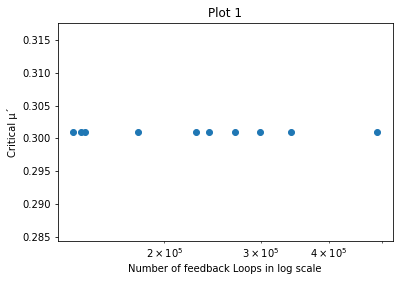

TypeError: ignored

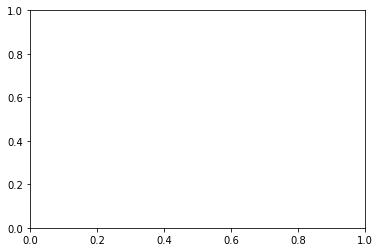

In [ ]:
x = np.array(Plot1x)
y = np.array(Plot1y)
#x_new = np.linspace(x.min(), x.max(),500)
#f = interp1d(x, y, kind='linear')
#y_smooth=f(x_new)
plt.scatter(x,y)
print(spearmanr(x,y))
#plt.plot(x_new,y_smooth,'-m')
#plt.plot(Plot1x,Plot1y,'-m')
plt.xscale('log')
plt.axis('tight')
plt.xlabel('Number of feedback Loops in log scale')
plt.ylabel('Critical \u03BC\u00B4')
plt.title('Plot 1')
plt.show()


x = np.array(Plot2x)
y = np.array(Plot2y)
#x_new = np.linspace(x.min(), x.max(),500)
#f = interp1d(x, y, kind='slinear')
#y_smooth=f(x_new)
plt.scatter(x,y,'.g')
#plt.plot(Plot2x,Plot2y,'-.g')
plt.axis('tight')
plt.xlabel('Average length of feedback Loop')
plt.ylabel('Critical mu_G')
plt.title('Plot 2')
plt.show()


x = np.array(Plot3x)
y = np.array(Plot3y)
#x_new = np.linspace(x.min(), x.max(),500)
#f = interp1d(x, y, kind='slinear')
#y_smooth=f(x_new)
plt.scatter(x,y,'.r')

#plt.plot(Plot3x,Plot3y,':r')
plt.axis('tight')
plt.xlabel('Avg loops per edge')
plt.ylabel('Critical mu_G')
plt.title('Plot 3')
plt.show()


SpearmanrResult(correlation=nan, pvalue=nan)


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


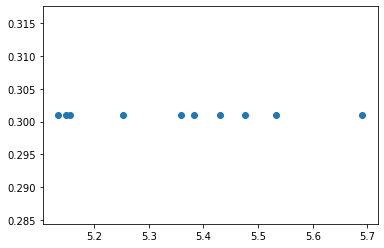

SpearmanrResult(correlation=nan, pvalue=nan)


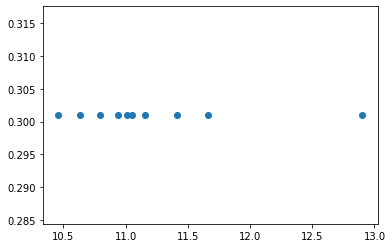

SpearmanrResult(correlation=nan, pvalue=nan)


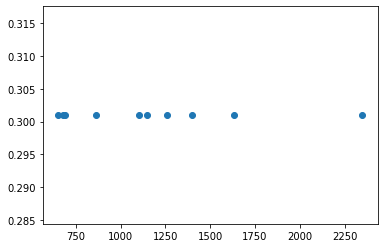

In [ ]:
Final_obs = np.array(Final_obs2)
for i in range(1,4):
    if i ==1:
        plt.scatter(np.log10(Final_obs[:,i]), Final_obs[:,0])
        print(spearmanr(np.log10(Final_obs[:,i]), Final_obs[:,0]))
        plt.show()
    else:
        plt.scatter(Final_obs[:,i], Final_obs[:,0])
        print(spearmanr(Final_obs[:,i], Final_obs[:,0]))
        plt.show()

In [ ]:

n = 6
G = nx.complete_graph(n, nx.DiGraph())
ctr = 0;
for i in nx.simple_cycles(G):
    if len(i)>1:
        ctr+=1
print(ctr)

409


### simple cycles

In [ ]:
t1 = time()
G = BankingGraph(8,20,1000)
L = ilen(nx.simple_cycles(G))
print(time() - t1)

In [ ]:
L

In [ ]:

from collections import deque
from itertools import count

def ilen(it):
    # Make a stateful counting iterator
    cnt = count()
    # zip it with the input iterator, then drain until input exhausted at C level
    deque(zip(it, cnt), 0) # cnt must be second zip arg to avoid advancing too far
    # Since count 0 based, the next value is the count
    return next(cnt)